# Task6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
import csv

with open('/content/movies.csv', 'r', encoding='utf-8', errors='ignore') as infile, \
     open('/content/movies_clean.csv', 'w', encoding='utf-8', newline='') as outfile:
    writer = csv.writer(outfile)
    for row in csv.reader(infile):
        writer.writerow(row)

df = pd.read_csv('/content/movies_clean.csv')

ratings = pd.read_csv('/content/ratings.csv')

In [62]:
df = df.dropna(subset=['id'])
df_cb = df[['genres','keywords','cast','crew','id','title']].fillna('').astype(str).apply(lambda x: x.str.lower())

In [63]:
df = df.dropna(subset=['id'])
df_cb = df[['genres','keywords','cast','crew','id','title']].fillna('').astype(str).apply(lambda x: x.str.lower())

In [64]:
# Keep only needed columns for CB
ratings = ratings[ratings['movieId'].isin(df['id'].astype(int))]

In [65]:
# -------------------------------
# 3. Time-aware split (leave-one-out per user)
# -------------------------------
ratings_sorted = ratings.sort_values(['userId', 'timestamp'])
test_size = 5  # last 5 ratings
train = ratings_sorted.groupby('userId', group_keys=False).apply(lambda x: x.iloc[:-test_size])
test = ratings_sorted.groupby('userId', group_keys=False).apply(lambda x: x.iloc[-test_size:])

train_matrix = train.pivot(index='userId', columns='movieId', values='rating').fillna(0)

/tmp/ipython-input-677233376.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = ratings_sorted.groupby('userId', group_keys=False).apply(lambda x: x.iloc[:-test_size])
/tmp/ipython-input-677233376.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = ratings_sorted.groupby('userId', group_keys=False).apply(lambda x: x.iloc[-test_size:])


In [66]:
# -------------------------------
# 4. CB matrix (TF-IDF or CountVectorizer)
# -------------------------------
vec = CountVectorizer()  # can switch to TfidfVectorizer for ablation
cb_matrix = vec.fit_transform(df_cb.apply(lambda x: ' '.join(x), axis=1))
cb_sim = cosine_similarity(cb_matrix)

In [67]:
# Map movie IDs to indices in df
movie_id_to_idx = {int(mid): i for i, mid in enumerate(df['id'].astype(int))}

In [74]:
def recommend_hybrid(user_id, top_k=20, alpha=0.7):
    if user_id not in train_matrix.index:
        # fallback: top popular movies
        return df['id'].astype(int).tolist()[:top_k]

    # CF part
    sCF = train_matrix.loc[user_id]
    sCF_full = np.zeros(len(df))
    rated_indices = []

    for mid, score in sCF.items():
        if mid in movie_id_to_idx:
            idx = movie_id_to_idx[mid]
            sCF_full[idx] = score
            rated_indices.append(idx)

    # CB part: weighted by user ratings
    if rated_indices:
        sCB = np.zeros(len(df))
        for idx in rated_indices:
            sCB += sCF_full[idx] * cb_sim[idx]  # weight by rating
        sCB /= sCF_full[rated_indices].sum()
    else:
        sCB = np.zeros(len(df))
        # Mask already rated movies (don’t recommend them)
    already_rated_mask = np.array([i in rated_indices for i in range(len(df))])
    sCF_full[already_rated_mask] = 0
    sCB[already_rated_mask] = 0

    # Normalize
    scaler = MinMaxScaler()
    sCF_norm = scaler.fit_transform(sCF_full.reshape(-1,1)).flatten()
    sCB_norm = scaler.fit_transform(sCB.reshape(-1,1)).flatten()

    # Hybrid score
    s_hyb = alpha * sCF_norm + (1-alpha) * sCB_norm

    # Top-K recommended movie IDs
    top_indices = s_hyb.argsort()[::-1][:top_k]
    recommended_movie_ids = df.iloc[top_indices]['id'].astype(int).tolist()
    return recommended_movie_ids

In [75]:
def precision_at_k(recommended, relevant):
    if len(recommended) == 0:
        return 0.0
    return len(set(recommended) & set(relevant)) / len(recommended)

def recall_at_k(recommended, relevant):
    if len(recommended) == 0:
        return 0.0
    return len(set(recommended) & set(relevant)) / len(relevant)

def hit_rate_at_k(recommended, relevant):
    if len(recommended) == 0:
        return 0
    return int(len(set(recommended) & set(relevant)) > 0)

In [70]:
common_ids = set(df['id'].astype(int)) & set(ratings['movieId'])
print(len(common_ids), "common movies between df and ratings")

446 common movies between df and ratings


In [76]:
Ks = [10, 20]
metrics_summary = []

unique_users = test['userId'].unique()
user_recs = {user: recommend_hybrid(user, top_k=max(Ks)) for user in unique_users}

for K in Ks:
    precisions, recalls, hits = [], [], []
    for user in unique_users:
        relevant_movies = set(test[test['userId'] == user]['movieId'])
        recs = user_recs[user][:K]
        precisions.append(precision_at_k(recs, relevant_movies))
        recalls.append(recall_at_k(recs, relevant_movies))
        hits.append(hit_rate_at_k(recs, relevant_movies))

    metrics_summary.append({
        'K': K,
        'Precision@K': np.mean(precisions),
        'Recall@K': np.mean(recalls),
        'HitRate@K': np.mean(hits)
    })

metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)

    K  Precision@K  Recall@K  HitRate@K
0  10     0.000241  0.000482    0.00241
1  20     0.000241  0.000964    0.00241


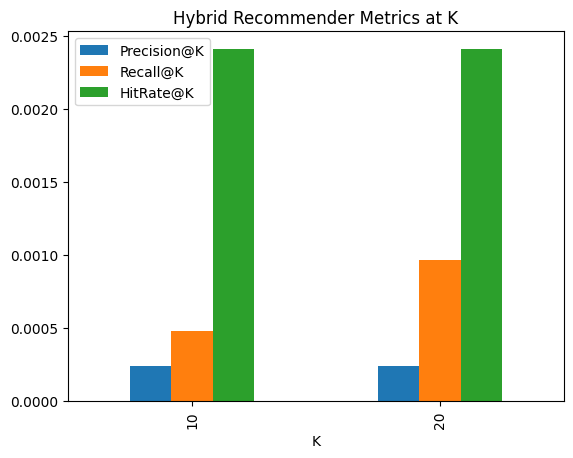

In [77]:
metrics_df.set_index('K').plot(kind='bar')
plt.title("Hybrid Recommender Metrics at K")
plt.show()
